In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from google.colab import files

uploaded = files.upload()


In [3]:
import zipfile
import os

# 假设你上传的文件名是 'data.zip'
zip_file_name = 'data.zip'  # 替换为你上传的文件名
extract_folder_path = '/content/data_extracted'  # 指定解压路径

# 解压缩文件
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)

print(f"Extracted files to: {extract_folder_path}")


Extracted files to: /content/data_extracted


In [4]:
# 指定解压缩后的文件夹路径
extracted_folder_path = '/content/data_extracted'  # 根据你的实际路径调整

# 检查文件夹是否存在并列出其中的文件
if os.path.exists(extracted_folder_path):
    extracted_files = os.listdir(extracted_folder_path)
    print("Files and directories in the extracted folder:")
    for file in extracted_files:
        print(file)
else:
    print(f"Directory does not exist at path: {extracted_folder_path}")


Files and directories in the extracted folder:
data


In [6]:
# 使用完整路径
long_sound_dir = '/content/data_extracted/data/positive/long_sound'
short_sound_dir = '/content/data_extracted/data/positive/short_sound'
negative_dir = '/content/data_extracted/data/negative'

# 检查路径是否存在
print(f"Checking long sound directory: {long_sound_dir}, Exists: {os.path.exists(long_sound_dir)}")
print(f"Checking short sound directory: {short_sound_dir}, Exists: {os.path.exists(short_sound_dir)}")
print(f"Checking negative directory: {negative_dir}, Exists: {os.path.exists(negative_dir)}")


Checking long sound directory: /content/data_extracted/data/positive/long_sound, Exists: True
Checking short sound directory: /content/data_extracted/data/positive/short_sound, Exists: True
Checking negative directory: /content/data_extracted/data/negative, Exists: True


In [7]:
def generate_audio_targets(data_dir):
    audio_files = []
    targets = []

    # 遍历正类和负类文件夹
    for class_label in ['positive', 'negative']:
        class_dir = os.path.join(data_dir, class_label)

        if class_label == 'positive':
            # 如果是正类，进一步区分长音和短音
            for sound_type in ['long_sound', 'short_sound']:
                sound_dir = os.path.join(class_dir, sound_type)

                # 遍历文件夹中的所有音频文件
                for file_name in os.listdir(sound_dir):
                    if file_name.endswith('.wav'):  # 假设是wav格式
                        file_path = os.path.join(sound_dir, file_name)
                        audio_files.append(file_path)

                        # 正类音频，target = 1
                        targets.append(1)
        else:
            # 负类，没有长短音区分
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(class_dir, file_name)
                    audio_files.append(file_path)

                    # 负类音频，target = 0
                    targets.append(0)

    return audio_files, targets

# 使用示例
data_dir = '/content/data_extracted/data/'
audio_files, targets = generate_audio_targets(data_dir)

# 打印一些结果
for i in range(5):
    print(f"Audio File: {audio_files[i]}, Target: {targets[i]}")


Audio File: /content/data_extracted/data/positive/long_sound/positive-DS3-8B-202206160646-1.wav, Target: 1
Audio File: /content/data_extracted/data/positive/long_sound/positive-NS1-1A5B-202201100842-5.wav, Target: 1
Audio File: /content/data_extracted/data/positive/long_sound/positive-DS3-13C 2A-202204130620-1.wav, Target: 1
Audio File: /content/data_extracted/data/positive/long_sound/positive-DS3-8B-202204130626-8.wav, Target: 1
Audio File: /content/data_extracted/data/positive/long_sound/positive-DS3-23C-202201051625-1.wav, Target: 1


In [9]:
import numpy as np

# 自定义数据集
class AudioDataset(Dataset):
    def __init__(self, audio_files, targets):
        self.audio_files = audio_files
        self.targets = targets  # 直接使用目标

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        # 加载音频文件
        waveform, sample_rate = torchaudio.load(self.audio_files[idx])
        # 提取特征（例如MFCCs）
        mfcc = torchaudio.transforms.MFCC()(waveform)
        # 获取标签（0或1）
        label = self.targets[idx]
        return mfcc, label

# 将 audio_files 和 targets 转换为 numpy 数组
audio_files = np.array(audio_files)
targets = np.array(targets)

# 随机打乱顺序
indices = np.arange(len(audio_files))
np.random.shuffle(indices)  # 随机排列索引
audio_files = audio_files[indices]
targets = targets[indices]

# 创建数据集
audio_dataset = AudioDataset(audio_files.tolist(), targets.tolist())

# 创建数据加载器
data_loader = DataLoader(audio_dataset, batch_size=32, shuffle=True)


In [27]:
import torch
import torch.nn as nn

class AudioLSTM(nn.Module):
    def __init__(self, n_feature=2647, out_feature=1, n_hidden=256, n_layers=2, drop_prob=0.5):
        super(AudioLSTM, self).__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_feature = n_feature

        # LSTM 层
        self.lstm = nn.LSTM(self.n_feature, self.n_hidden, self.n_layers,
                            dropout=self.drop_prob, batch_first=True)

        # Dropout 层
        self.dropout = nn.Dropout(drop_prob)

        # 输出层
        self.fc = nn.Linear(n_hidden, out_feature)

        # Sigmoid 激活函数
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        # x.shape (batch, seq_len, n_features)
        l_out, l_hidden = self.lstm(x, hidden)

        # out.shape (batch, seq_len, n_hidden*direction)
        out = self.dropout(l_out)

        # out.shape (batch, out_feature)
        out = self.fc(out[:, -1, :])  # 取序列的最后一个时间步的输出

        # 使用 Sigmoid 将输出转换为概率
        out = self.sigmoid(out)

        # return the final output and the hidden state
        return out, l_hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data

        # 初始化隐藏状态
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        return hidden


In [15]:
from torch.utils.data import random_split
# 设置训练集和测试集的比例
train_ratio = 0.8  # 80% 用于训练
test_ratio = 0.2   # 20% 用于测试

# 计算数据集的大小
dataset_size = len(audio_dataset)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size  # 确保总数不变

# 划分数据集
train_dataset, test_dataset = random_split(audio_dataset, [train_size, test_size])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [31]:
# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义损失函数
criterion = nn.BCELoss()  # 二元交叉熵损失

In [32]:
import matplotlib.pyplot as plt

# 保存损失和准确率
train_losses = []
test_accuracies = []

In [36]:
def train(model, train_loader, epoch, num_epochs, optimizer):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0

    for batch_idx, (data, targets) in enumerate(train_loader):
        # 将数据和目标转移到设备
        data, targets = data.to(device), targets.to(device).float()  # 确保目标是浮点数

        # 使用 squeeze 去掉第二个维度
        data = data.squeeze(1)  # 此时数据的形状将变为 (batch_size, seq_length, n_features)

        # 初始化隐藏状态
        hidden = model.init_hidden(data.size(0))

        # 清零梯度
        optimizer.zero_grad()

        # 前向传播
        outputs, hidden = model(data, hidden)

        # 计算损失
        loss = criterion(outputs, targets.unsqueeze(1))  # 添加一个维度以匹配输出形状

        # 反向传播和优化
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 输出每个 epoch 的损失
        if batch_idx % 10 == 0:  # 每 10 个 batch 打印一次
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)  # 保存训练损失
    print(f'Average Loss for Epoch [{epoch+1}]: {average_loss:.4f}')


In [37]:
def test(model, test_loader):
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0

    with torch.no_grad():  # 不需要计算梯度
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device).float()

            # 使用 squeeze 去掉第二个维度
            data = data.squeeze(1)  # 此时数据的形状将变为 (batch_size, seq_length, n_features)

            # 初始化隐藏状态
            hidden = model.init_hidden(data.size(0))

            # 前向传播
            outputs, hidden = model(data, hidden)

            # 将输出转换为 0 或 1
            predicted = (outputs >= 0.5).float()  # 阈值 0.5

            total += targets.size(0)
            correct += (predicted.squeeze() == targets).sum().item()  # 统计正确的预测

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)  # 保存测试准确率
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')


In [38]:
# 创建模型实例
model = AudioLSTM(n_feature=2647, out_feature=1, n_hidden=256, n_layers=2, drop_prob=0.5).to(device)

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练和测试模型
num_epochs = 10  # 设置总的训练轮数
for epoch in range(num_epochs):
    train(model, train_loader, epoch, num_epochs, optimizer)  # 训练
    test(model, test_loader)  # 测试


Epoch [1/10], Step [0/3], Loss: 0.7036
Average Loss for Epoch [1]: 0.7104
Accuracy of the model on the test set: 55.00%
Epoch [2/10], Step [0/3], Loss: 0.7025
Average Loss for Epoch [2]: 0.6821
Accuracy of the model on the test set: 60.00%
Epoch [3/10], Step [0/3], Loss: 0.6546
Average Loss for Epoch [3]: 0.6508
Accuracy of the model on the test set: 50.00%
Epoch [4/10], Step [0/3], Loss: 0.6387
Average Loss for Epoch [4]: 0.6187
Accuracy of the model on the test set: 50.00%
Epoch [5/10], Step [0/3], Loss: 0.5313
Average Loss for Epoch [5]: 0.5139
Accuracy of the model on the test set: 50.00%
Epoch [6/10], Step [0/3], Loss: 0.3543
Average Loss for Epoch [6]: 0.3249
Accuracy of the model on the test set: 40.00%
Epoch [7/10], Step [0/3], Loss: 0.1344
Average Loss for Epoch [7]: 0.1051
Accuracy of the model on the test set: 50.00%
Epoch [8/10], Step [0/3], Loss: 0.0244
Average Loss for Epoch [8]: 0.0595
Accuracy of the model on the test set: 55.00%
Epoch [9/10], Step [0/3], Loss: 0.0211
A

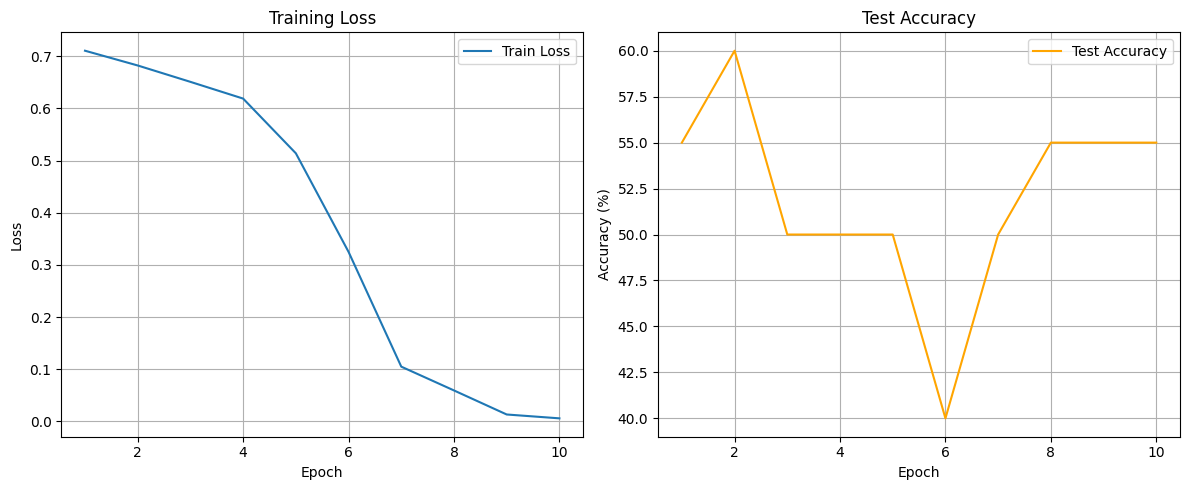

In [39]:
# 绘制损失和准确率图
plt.figure(figsize=(12, 5))

# 绘制训练损失
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.legend()

# 绘制测试准确率
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()